In [1]:
import sys
molgen_path = "../"
if molgen_path not in sys.path:
    sys.path.insert(0, molgen_path)

In [2]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem import AllChem
from utils import MonomersLib, HELMConverter, draw_mol, get_main_mol, remove_isotopes, is_same_mol

lib = MonomersLib()
monomers_lib_path = molgen_path + "data/helm/library/HELMCoreLibrary.json"
lib.load_json(monomers_lib_path)
monomers_lib_path = molgen_path + "data/helm/library/modan.json"
lib.load_json(monomers_lib_path)
converter = HELMConverter(lib)

[00:17:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[00:17:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[00:17:11] WARNING: not removing hydrogen atom with dummy atom neighbors
[00:17:11] WARNING: not removing hydrogen atom with dummy atom neighbors


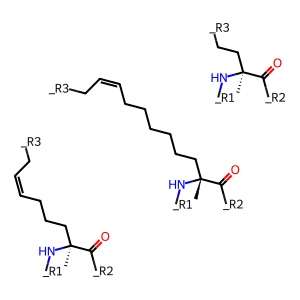

In [8]:
helm = "PEPTIDE1{[S5Left]}|PEPTIDE1{[S5Right]}|PEPTIDE1{[R8]}|}$$$$"
mol = converter._convert(helm, close=False)
draw_mol(mol, 300, 300)

True


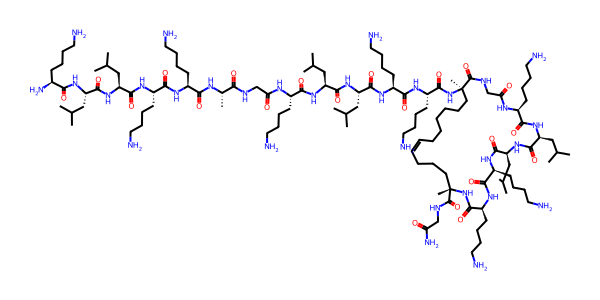

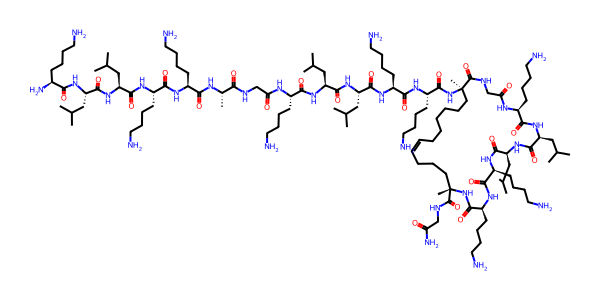

CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@]1(C)CCCCCC/C=C\CCC[C@@](C)(C(=O)NCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)CNC1=O
CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@]1(C)CCCCCC/C=C\CCC[C@@](C)(C(=O)NCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)CNC1=O


In [ ]:
width, height = 600, 300
helm, smiles = "PEPTIDE1{K.L.L.K.K.A.G.K.L.L.K.K.[R8].G.K.L.L.K.K.[S5Right].G.[am]}$PEPTIDE1,PEPTIDE1,13:R3-20:R3$$$", "NC(CNC([C@@](CCC/C=C\CCCCCC1)(C)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)NC(CNC([C@]1(C)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)NC(CNC([C@H](C)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)N)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O"
#H-KLLKKAGKLLKKR8GKLLKKS5G-NH2
mol_h = converter.convert(helm)
mol_s = Chem.MolFromSmiles(smiles)
print(is_same_mol(mol_h, mol_s))
draw_mol(mol_h, width=width, height=height)
draw_mol(mol_s, width=width, height=height)

print(Chem.MolToSmiles(mol_h))
print(Chem.MolToSmiles(mol_s))